In [ ]:
# Install packages
import sys

print("Installing packages: pytorch")
!{sys.executable} -m pip install torch==1.11.0

print("Installing geomstats and giotto-tda")
!{sys.executable} -m pip install geomstats==2.4.2
!{sys.executable} -m pip install giotto-tda==0.5.1

print("Installing matplotlib")
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install matplotlib-inline

print("Installing packages: numpy tqdm")
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm

print("Installing packages: sklearn scipy")
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install scipy

print("Installing packages: TopologyLayer")
!{sys.executable} -m pip install git+https://github.com/bruel-gabrielsson/TopologyLayer.git

# Topological Ensemble Detection with Differentiable Yoking **🧸**

**Authors:** David Klindt, Erik Hermansen, Melvin Vaupel and Benjamin Dunn 

**Affiliation:** Norwegian University of Science and Technology

# 1. Introduction

Recent work [(Gardner et. al, 2022)](https://www.nature.com/articles/s41586-021-04268-7) demonstrated that the joint activity of grid cells from an individual module resides on a toroidal manifold. Intuitively, we can think of each grid cell as having a receptive field, or tuning curve, on the surface of a 2-Torus [(Curto, 2017)](https://www.ams.org/journals/bull/2017-54-01/S0273-0979-2016-01554-0/S0273-0979-2016-01554-0.pdf):

<img src="https://i.imgur.com/vB2acJt.png" alt="Drawing" style="width: 500px;"/>

<h4><center>Figure: Illustration of the idea that each grid cell has a receptive field on a torus - each of the many fields shown represent the selectivity of a single neuron.</center></h4>

Topological data analysis (TDA) [(Wasserman, 2018)](https://www.annualreviews.org/doi/abs/10.1146/annurev-statistics-031017-100045?journalCode=statistics) studies the topological shapes in datasets. It has been used previously to discover the ring topology in head direction neural circuits [(Rybakken et al., 2019)](https://arxiv.org/pdf/1711.07205.pdf). The key instrument in the toolkit of TDA is the computation of persistent homology and its visualization as bar codes for the distinct homology classes. 

The typical toroidal signature can be seen in Fig.1e [(Gardner et. al, 2022)](https://www.nature.com/articles/s41586-021-04268-7) as well as below in this notebook. Specifically, persistent homology of a 2-Torus manifold should discover two significant H_1 (circles) bars and one significant H_2 (volume) bar. Crucially, this toroidal organization becomes only apparent after separating the distinct grid cell modules. Each grid cell module tiles the space in which an animal navigates in a hexagonal pattern. The distinct modules have different spatial resolutions and remap independently across environments ([(Fyhn et al., 2007)](https://www.nature.com/articles/nature05601).

In cases where the encoded covariate, e.g., space have been recorded, one can use this additional data to separate the different modules, for instance, by clustering their spatial autocorrelation functions [(Gardner et. al, 2022)](https://www.nature.com/articles/s41586-021-04268-7). These function vary as a function of the spatial resolution and can, therefore, lend themselves as a useful proxy to determine the module indentity of each cell. However, in the absence of such additional information, or even more broadly in other tasks where the covariate is unknown [(Constantinescu et al., 2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5248972/), we need an unsupervised clustering approach that infers the distinct cell ensembles solely based on the topological structure of their population activity. Developing such an approach based on `Geomstats` and recent advances in computational topology [(Brüel-Gabrielsson et al., 2020)](https://arxiv.org/pdf/1905.12200.pdf) is the purpose of this notebook. As a <i>proof-of-concept</i> this is validated on simulated data.

# 2. Approach

## 2.1. Problem

Let $X \in \mathbb{R}^{t \times n}$ be a recording of $t$ instantaneous firing rates from $n$ neurons.
Let $PH_k(X)$ denote the persistent homology of the Rips filtration for the $k$-th dimension, which can be decomposed into a sum of elementary persistence intervals

\begin{equation}
    PH_k(X) \simeq \bigoplus_i I([b_i, d_i]).
\end{equation}

What we want to find is a subset of neurons $E \subseteq X$ with $E \in \mathbb{R}^{t \times m}, m \leq n$ that form an <i>ensemble</i>.
Specifically, our hypothesis is that $E=\{E_0, \ldots, E_t\}$ consists of $t$ (noisy) samples from the surface of a $p$-dimensional Torus $\mathbf{T}^p$. Here we focus on ensembles with state space activity dominated by a single $p$-dimensional torus, however the idea could be generalised to other situations.


## 2.2. Topological Loss Function

Since a torus is the product space of circles, we can also write $\mathbf{T}^p = S_1 \times \ldots \times S_p$.
Therefore, for samples from a $p$-dimensional torus we would expect $p$ bars $[b_i, d_i]_{i \in I = \{j_1, \ldots j_p \}}$ of significant length that are clearly distinct from the remaining bars, that are assumed to be mostly noise.

\begin{equation}
    PH_k(E) \simeq \left(\bigoplus_{i \in I} I([b_i, d_i])\right) \oplus \left(\bigoplus_{i \notin I} I([b_i, d_i])\right).
\end{equation}

To obtain these bars we can simply order all bars in decreasing lengths like $d_{j_k} - b_{j_k} \geq d_{j_k+1} - b_{j_k+1} \forall j \in J$.
Then we should have $I = \{j_1, \ldots, j_p\}$.

We make this the objective of our ensemble detection with the following loss function

\begin{equation}
    \mathcal{L}(X) := \left(\sum_{i \notin I} d_i - b_i\right) - \left(\sum_{i \in I} d_i - b_i\right)
\end{equation}

that is, we want to maximize the lifetime of the $p$ significant bars, corresponding to the $S_1 \times \ldots \times S_p$ circles of the ensemble $E$, and minimize the lifetimes of all remaining bars. One possible such loss function (tested in simulations below) would simple be as follows

\begin{equation}
    \mathcal{L}(X) := \sum_{i \notin I} (d_i - b_i) - \sum_{i \in I} (d_i - b_i).
\end{equation}

To find $E$, we have to select among all possible subsets $E_1, \ldots E_N$ of $X$.
The motivation behind this approach is that we hope that the minimum of $\mathcal{L}$ will, <i>modulo</i> sampling noise, return the correct ensemble

\begin{equation}\label{eq:min_ensemble}
    E = \min \{\mathcal{L}(E_1), \ldots, \mathcal{L}(E_N)\}.
\end{equation}

Unfortunately, even if we know $m$ we still have $N={n\choose m}$ distinct subsets to pick from.
Thus, the brute force combinatorial approach does not scale beyond a few neurons.


## 2.3. Differentiable Yoking

Luckily, $\mathcal{L}$ is differentiable almost everywhere ([Solomon et al, 2021](http://proceedings.mlr.press/v130/solomon21a/solomon21a.pdf), [Brüel-Gabrielsson et al., 2020](https://arxiv.org/pdf/1905.12200.pdf)) and we can approach the discrete search, i.e. clustering (yoking), for $E$ in the following way.
Let

\begin{equation}
    \sigma(W)_{:,j} := \frac{\exp W_{:,j}}{\sum_i \exp W_{ij}}
\end{equation}

be the softmax function applied to each column of the matrix $W \in \mathbb{R}^{n \times n}$.
Then let $f: \mathbb{R}^{t \times n} \rightarrow \mathbb{R}^{t \times n}, f_W(X) := X\sigma(W)$ be a linear function that multiplies our dataset with this matrix $\sigma(W)$.
Thus, each column $f_W(X)_{:,i} \in \mathbb{R}^n$ is a <i>convex combination</i> of $X$, since $\sum_i \sigma(W)_{ij} = 1, \forall j$ and $\sigma(W)_{ij} > 0, \forall i,j$.

Let $W^* = \min_W \mathcal{L}(f_W(X))$, then because of the convex combination, we have the following

\begin{equation}
    \mathcal{L}(f_{W^*}(X)) \approx \mathcal{L}(E)
\end{equation}

At this minimum, we expect to find an $m \times m$ submatrix of $W$ which is approximately a permutation $\sigma(W)_{ij} \in S_m$.
The reason for this is that $\mathcal{L}$ is invariant to input permutations, i.e., $\mathcal{L} \circ s(E) = \mathcal{L} \circ s'(E), \forall s, s' \in S_m$.
And, more importantly, according to our choice of $E$, selecting the correct subset $E$ should minimize $\mathcal{L}$.
Moreover, none of the other neurons should be selected $\sigma(W)_i \approx 0, \forall i \notin I$, because including those in the transformed dataset would reduce the lifetime of the longest cycles in $E$ or increase the lifetime of noisy cycles in $X \setminus E$, which would increase $\mathcal{L}(f_W(X))$.

Because every column sums to $1$, some neurons from $E$ will be selected multiple times by $\sigma(W)$.
However, in a simple post processing step we simply determine the ensemble we were looking for as

\begin{equation}
    \hat{E} := \left\{X_i | \sum_i \sigma(W^*)_{:,i} > \theta \right\}
\end{equation}

for some threshold $\theta > 0$, for instance, $\theta = \text{median}(\sum_i \sigma(W^*)_i)$.


## Library contributions

We propose the following implementations:

#### Geomstats: dist_broadcast for toroidal manifolds

Located in the `/geomstats_additions.py` file. This defines the [dist_broadcast](https://github.com/geomstats/geomstats/blob/60dedbc6bff239016c389b5439aff9dcb87cf6dd/geomstats/geometry/riemannian_metric.py#L301) function for NFoldManifold objects with $S^1$ (`Hypersphere(dim=1)`) components.

#### Geomstats/TopologyLayer: integration

We propose to integrate the TopologyLayer [implementation](https://github.com/bruel-gabrielsson/TopologyLayer) to Geomstats.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import time
global_t0 = time.time()  # measure execution time of complete notebook

import types
import numpy as np
import torch
import pickle
from tqdm import trange
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import geomstats.backend as gs
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.product_manifold import ProductManifold, NFoldManifold
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
from geomstats.geometry.euclidean import Euclidean

from model import Teddy
from data_helper import generate_data, convert_to_angles, convert_to_points, make_population
from geomstats_additions import dist_broadcast_l2
from tda_helper import compute_persistence, plot_persistence_diagrams, giotto_objective_function

device = "cuda" if torch.cuda.is_available() else "cpu"
print('Running on', device)

INFO: Using numpy backend


test angle/vector conversions: passed.
Running on cpu


In [2]:
# Set global seed for simulations
global_seed = 42

# 3. Data Generation

Using Geomstats, we will generate grid cell responses (on a 2-Torus). Furthermore, for comparison, we will also generate neural ensembles with population activity living on other manifolds including: $S^1$, $\mathbb{R}^2$ and $SO(3)$. For this purpose, we proceed as follows:

<ol>
  <li>Generate random points on the manifold as neural receptive field centers.</li>
  <li>Generate random points on the manifold as latent/covariate states.</li>
  <li>Compute the geodesic distances between the two sets of points.</li>
  <li>Compute Gaussian-bump like tuning curves based on the geodesic distances.</li>
  <li>Add realistic neural poisson noise.</li>
</ol>

In [3]:
# Parameters
num_neurons = 100
num_data = 300
mean_firing_rate = 5.0

In [4]:
# Generate manifolds
manifolds = {
    "S1": Hypersphere(dim=1),
    "R2": Euclidean(dim=2),
    "SO3": SpecialOrthogonal(n=3, point_type="vector"),
}
manifolds["T2"] = NFoldManifold(manifolds["S1"], n_copies=2)

In [5]:
# Define dist_broadcast for T2 (L2 norm across component manifolds) and bind it.
manifolds["T2"].metric.dist_broadcast = types.MethodType(
    dist_broadcast_l2, manifolds["T2"])

Because each manifold has a different metric, we find that we need to adjust the width of the tuning curves and their relative response scaling to achieve homogeneously active populations of neurons for each of the manifolds. Thus, we perform a quick optimization over tuning width (sigma) and respone scaling (scale) to find ensembles with a biologically plausible approximate $5$Hz mean firing rate and approximate standard deviation also $5$ (without controlling the latter as well, we might end up with extremely broad tuning curves and a scaling that keeps neurons constantly firing at $5$Hz).

In [6]:
# Optimize scale and sigma for each manifold to achieve mean_firing_rate
t0 = time.time()
sigmas = {}
scales = {}

for m in manifolds:
    def loss(x):
        scale, sigma = x
        data = generate_data(manifold=manifolds[m], num_neurons=num_neurons, 
                             num_data=num_data, sigma=sigma, 
                             scale=scale, seed=global_seed)
        mean = data['responses_clean'].mean(1).mean()
        std = data['responses_clean'].std(1).mean()
        return (mean - mean_firing_rate)**2 + (std - mean_firing_rate)**2

    x0 = [20, 1]
    res = minimize(loss, x0, bounds=[(1, 30), (.1, 5)])
    print("%s: best fitting scale=%.4f and sigma=%.4f" % (m, res.x[1], res.x[0]))
    sigmas[m] = res.x[1]
    scales[m] = res.x[0]
print("Cell execution took %.2fs" % (time.time() - t0))

S1: best fitting scale=1.5798 and sigma=14.1331
R2: best fitting scale=0.6185 and sigma=17.4582
SO3: best fitting scale=0.2225 and sigma=21.6422
T2: best fitting scale=3.3360 and sigma=19.3815
Cell execution took 4.65s


In [7]:
# Generate data
data = {}
for m in manifolds:
    print("Testing:", m)
    data[m] = generate_data(manifold=manifolds[m], num_neurons=num_neurons, 
                            num_data=num_data, sigma=sigmas[m], 
                            scale=scales[m], seed=global_seed)
    print(
        "Output shapes:", [(key, data[m][key].shape) for key in data[m] if key is not 'responses_clean'],
        "\n",
        "Mean firing rate: %.8f," % data[m]['responses_clean'].mean(1).mean(),
        "Mean S.D. of firing rate: %.8f" % data[m]['responses_clean'].std(1).mean()
    )

Testing: S1
Output shapes: [('centers', (100, 2)), ('latents', (300, 2)), ('responses', (100, 300))] 
 Mean firing rate: 4.99999939, Mean S.D. of firing rate: 5.00000038
Testing: R2
Output shapes: [('centers', (100, 2)), ('latents', (300, 2)), ('responses', (100, 300))] 
 Mean firing rate: 4.99999948, Mean S.D. of firing rate: 4.99999964
Testing: SO3
Output shapes: [('centers', (100, 3)), ('latents', (300, 3)), ('responses', (100, 300))] 
 Mean firing rate: 5.00000002, Mean S.D. of firing rate: 4.99999941
Testing: T2
Output shapes: [('centers', (100, 2, 2)), ('latents', (300, 2, 2)), ('responses', (100, 300))] 
 Mean firing rate: 5.00000136, Mean S.D. of firing rate: 4.99999948


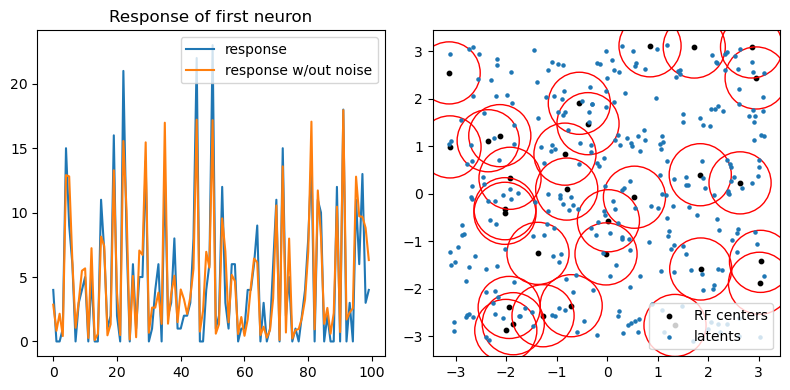

In [8]:
# Visualize data on T2
num_show = 30  # don't show all neurons to avoid clutter

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Response of first neuron")
plt.plot(data["T2"]["responses"][0, :100], label='response')
plt.plot(data["T2"]["responses_clean"][0, :100], label='response w/out noise')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(*convert_to_angles(data["T2"]["centers"][:num_show]).T, s=10, color='black', 
            label='RF centers')
plt.scatter(*convert_to_angles(data["T2"]["centers"][:num_show]).T, s=2000, 
            facecolors='none', edgecolors='r', label=None)
plt.scatter(*convert_to_angles(data["T2"]["latents"]).T, s=5, label='latents')
plt.legend()

plt.tight_layout()
plt.show()

## 3.1. Persistent Homology of Neural Responses

We will now use the `VietorisRipsPersistence` from `Giotto-TDA` to compute the persistent homology (up to dimension 2) for the neural response matrices from each latent manifold. Importantly, we treat each instance in time as a separate sample in a space of the same dimensionality as the number of neurons.

Computing Persistent Homology of neural responses on manifold: S1
Computing Persistent Homology of neural responses on manifold: R2
Computing Persistent Homology of neural responses on manifold: SO3
Computing Persistent Homology of neural responses on manifold: T2


INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral


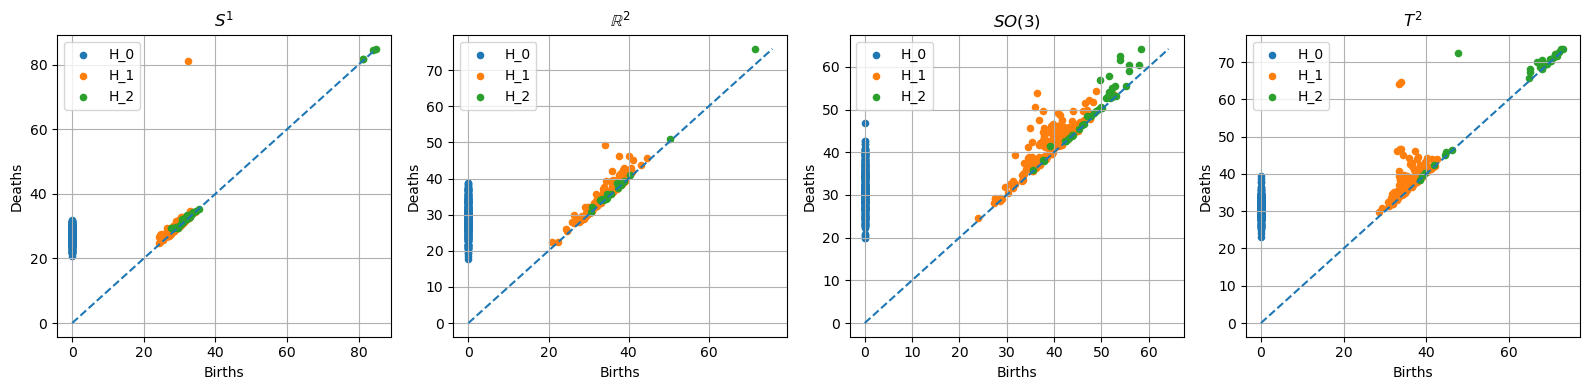

Cell execution took 5.55s


In [9]:
# Compute Persistent Homology of all Data
t0 = time.time()
persistence_diagrams = []
for m in data:
    print("Computing Persistent Homology of neural responses on manifold:", m)
    persistence_diagrams.append(
        compute_persistence(data[m]["responses"].T)
    )
plot_persistence_diagrams(
    persistence_diagrams, 
    titles=[r"$S^1$", r"$\mathbb{R}^2$", r"$SO(3)$", r"$T^2$"]
)
print("Cell execution took %.2fs" % (time.time() - t0))

The persistence diagrams are as expected. For $S^1$ we find a signature with one significant circle ($H_1$). For $T^2$ we find two significant circles ($H_1$) and one significant volume in two dimensions ($H_2$). For $\mathbb{R}^2$ we find a few spurious $H_1$ and $H_2$, but no significant topological structure – those spurious featues, however, will become important again below. Finally, for $SO(3)$ one would expect significant bars in $H_0$ (which we always see) and $H_3$ (which we do not measure, due to the computational burden) (see [here](https://academic.csuohio.edu/bubenik_p/talks/msri.pdf) and [here](https://pi.math.cornell.edu/~hatcher/AT/AT.pdf)).

The crucial question is now: <i>What happens if we mix multiple ensembles?</i>

## 3.2. Persistent Homology of Mixed Neural Responses

Since we are mainly interested in grid cells, we will test what happens to the topological structure of neural population activity when a toroidal ensemble is paired with each of the other manifold (including $T^2$ itself to study the case of multiple mixed grid cell modules).

In [10]:
# Define the tested settings
settings = ["T2+T2", "T2+R2", "T2+S1", "T2+SO3"]
titles = [r"$T^2+T^2$", r"$T^2+\mathbb{R}^2$", r"$T^2+S^1$", r"$T^2+SO(3)$"]  # for plots
num_settings = len(settings)

Computing Persistent Homology of neural responses from T2+T2.
Computing Persistent Homology of neural responses from T2+R2.
Computing Persistent Homology of neural responses from T2+S1.
Computing Persistent Homology of neural responses from T2+SO3.


INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral


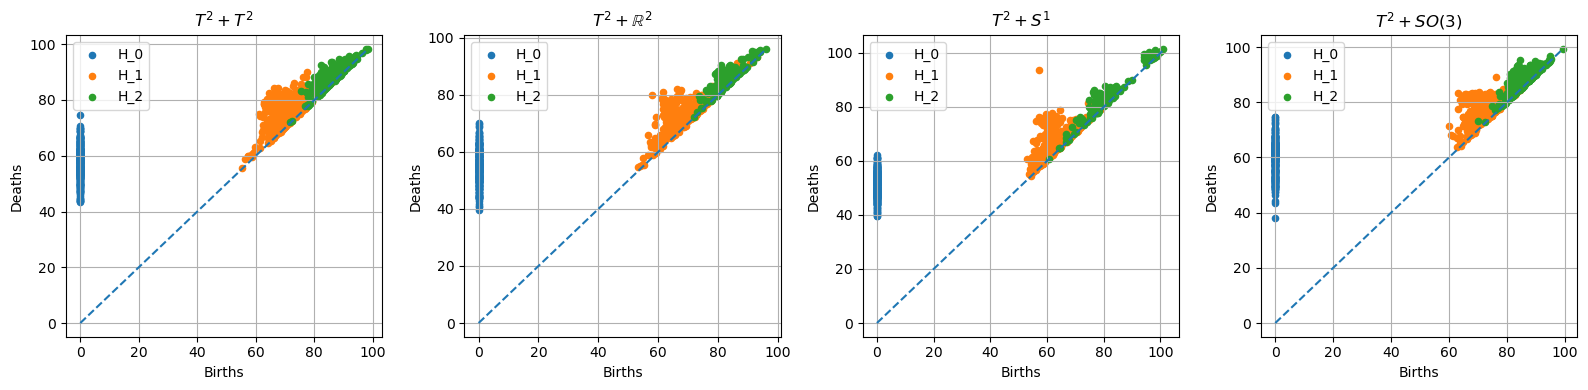

Cell execution took 8.36s


In [11]:
# Compute Persistent Homology of Mixed Data
t0 = time.time()
mixed_persistence_diagrams = []
for s in settings:
    print("Computing Persistent Homology of neural responses from %s." % s)
    mixed_responses = make_population(s, manifolds, num_neurons, num_data, 
                                      sigmas, scales, global_seed)
    mixed_persistence_diagrams.append(
        compute_persistence(mixed_responses.T)
)
plot_persistence_diagrams(mixed_persistence_diagrams, titles=titles)
print("Cell execution took %.2fs" % (time.time() - t0))

In almost all cases pairing different ensembles hides the topological signature of $T^2$ that we would have hoped to discover in the data. Interestingly, pairing neural ensembles from $T^2+S^1$ does not completely abolish the strong top $H_1$ signature of $S^1$ in the persistence diagram.

# 4. Algorithms

## 4.1. Baseline: KMeans Clustering

We will now begin by assessing how well neural ensembles can be separated with the classical KMeans algorithm. Since it is the most important case (with an eye on grid cell research), we will test this on the pairing of two neural ensembles each tuned to covariates on $T^2$. We will perform KMeans in the space of principal directions of the data and assess the clustering performance (with known ground truth) as a function of the number of directions included.

Computing KMeans Clustering of neural responses from T2+T2.
Computing KMeans Clustering of neural responses from T2+R2.
Computing KMeans Clustering of neural responses from T2+S1.
Computing KMeans Clustering of neural responses from T2+SO3.


INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral


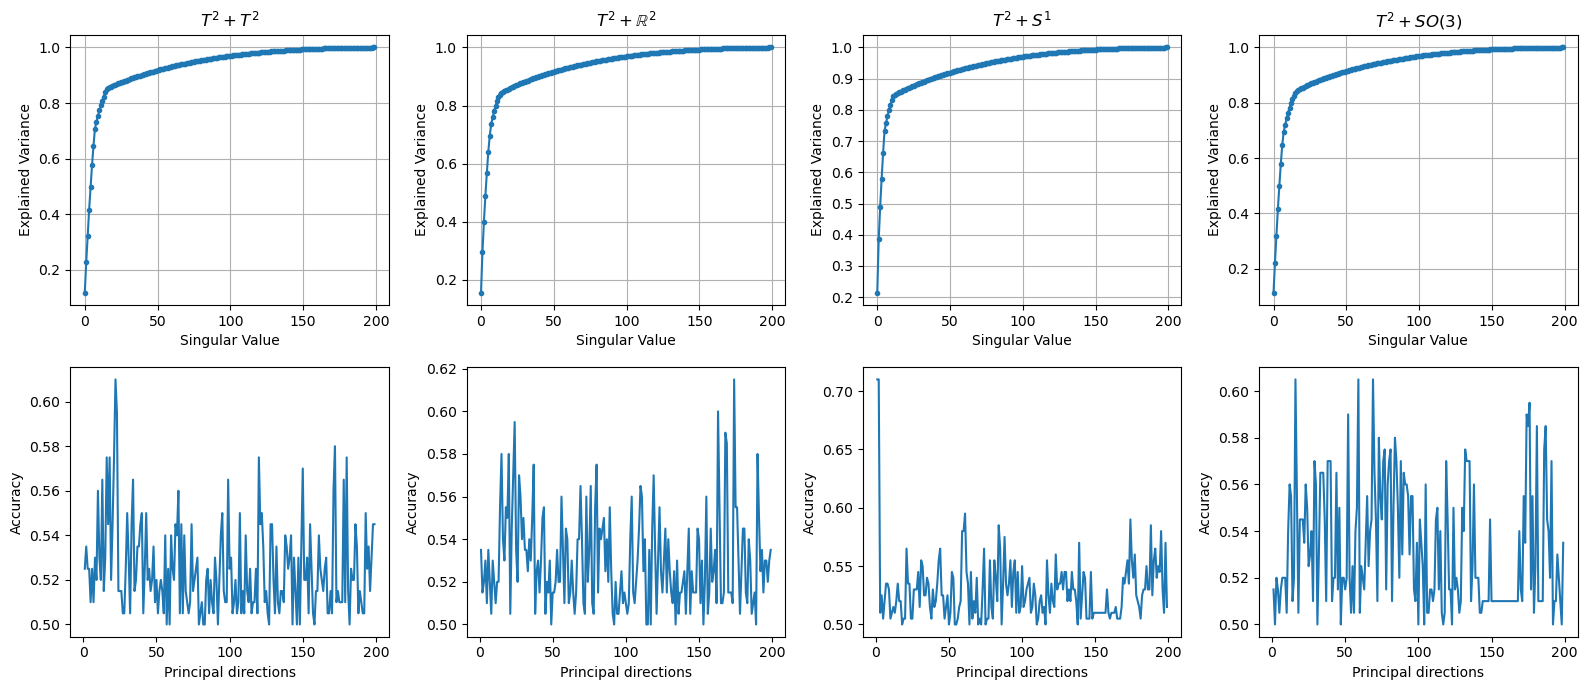

Cell execution took 8.66s


In [12]:
# for all settings
t0 = time.time()
plt.figure(figsize=(16, 7))
for i, setting in enumerate(settings):
    print("Computing KMeans Clustering of neural responses from %s." % setting)
    mixed_responses = make_population(setting, manifolds, num_neurons, num_data, 
                                      sigmas, scales, global_seed)
    
    # Compute singular value decomposition of neural population activity
    tmp = mixed_responses.copy().astype(np.float32)
    tmp -= np.mean(tmp, 1, keepdims=True)
    tmp /= np.std(tmp, 1, keepdims=True)
    u, s, v = np.linalg.svd(tmp)
    plt.subplot(2, num_settings, i + 1)
    var_exp = s**2 / np.sum(s**2)
    plt.plot(np.cumsum(var_exp), '.-')
    plt.grid()
    plt.xlabel("Singular Value")
    plt.ylabel("Explained Variance")
    plt.title(titles[i])
    
    # Compute Kmeans clustering (as a function of PCs)
    right = np.concatenate([np.zeros(100), np.ones(100)])
    accs = []
    dims = np.arange(1, u.shape[1])
    for dim in dims:
        kmeans = KMeans(n_clusters=2, random_state=global_seed).fit(u[:, :dim])
        acc = np.mean(kmeans.labels_ == right)
        if acc < .5:
            acc = 1 - acc
        accs.append(acc)
    plt.subplot(2, num_settings, i + 1 + num_settings)
    plt.plot(dims, accs)
    plt.xlabel("Principal directions")
    plt.ylabel("Accuracy")
    
plt.tight_layout()
plt.show()
print("Cell execution took %.2fs" % (time.time() - t0))

Chance level performance is at $50\%$. However, since both ensembles are identical we consider each possible labelling of the two modules equally valid. Nevertheless, we find that for all dimensions of the data, KMeans is not able to separate the two toroidal ensembles with an accuracy above $62\%$.

Interesetingly, there is a sharp knee at $16$ dimensions in the spectrum of singular values. We suspect that this might be due to the fact that we are observing two symmetric neural populations with responses to $T^2$. However, we leave it open how that results in an embedding dimension of $8$ per population. Moreover, this suggested that we might see good clustering performance in the first $16$ dimensions, assuming that the slower spectrum decay thereafter reflects mostly noise structure in the data.

## 4.2. A Topological Loss Function that Separates Ensembles

We will now test whether the topological loss function proposed in the introduction is actually able to tell apart ensembles of grid cell modules with different coefficient of module mixing. As compouting persistent homology is computationally expensive, we will also asses the minimum number of temporal samples required to make a reliable inference. 

<h4><center>Disclaimer: The next cell takes approx. 7min (on the machine used, see below) for 100 repetitions. If this exceeds the allowed computation time, simply adjust the number of repetitions. Alternatively, skip and load results from `results` folder.</center></h4>

In [13]:
# Check objective function for bs={16, 32}, mixing={.5, .6, .7, .8, .9, 1}
t0 = time.time()
num_samples = gs.array((8, 16, 32))
num_mix = gs.arange(0, 110, 10)
num_repeats = 100
num_settings = len(settings)

values = gs.zeros((num_settings, num_samples.size, num_mix.size, num_repeats, 5))
for s in range(num_settings):
    print("Computing objective function for setting:", settings[s])
    mixed_responses = make_population(settings[s], manifolds, num_neurons, 
                                      num_data, sigmas, scales, global_seed)
    responses_a = mixed_responses[:num_neurons].copy()
    responses_b = mixed_responses[num_neurons:].copy()

    with trange(num_repeats) as pbar:
        for k in pbar:
            np.random.seed(global_seed + k)
            ind_data = np.random.choice(num_data, num_data, replace=False)
            ind_neurons = np.random.choice(num_neurons, num_neurons, replace=False)
            for i, num_sample in enumerate(num_samples):
                for j, mix in enumerate(num_mix):
                    mixed = np.concatenate(
                        [responses_a[ind_neurons[:mix]][:, ind_data[:num_sample]],
                        responses_b[ind_neurons[mix:]][:, ind_data[:num_sample]]]
                    )
                    values[s, i, j, k] = giotto_objective_function(mixed.T)
                    
# save results
np.save('results/test_objective_function', values)
print("Cell execution took %.2fm" % ((time.time() - t0) / 60))

  0%|          | 0/100 [00:00<?, ?it/s]

Computing objective function for setting: T2+T2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing objective function for setting: T2+R2


  0%|          | 0/100 [00:00<?, ?it/s]

Computing objective function for setting: T2+S1


  0%|          | 0/100 [00:00<?, ?it/s]

Computing objective function for setting: T2+SO3


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

Cell execution took 6.49m


INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral


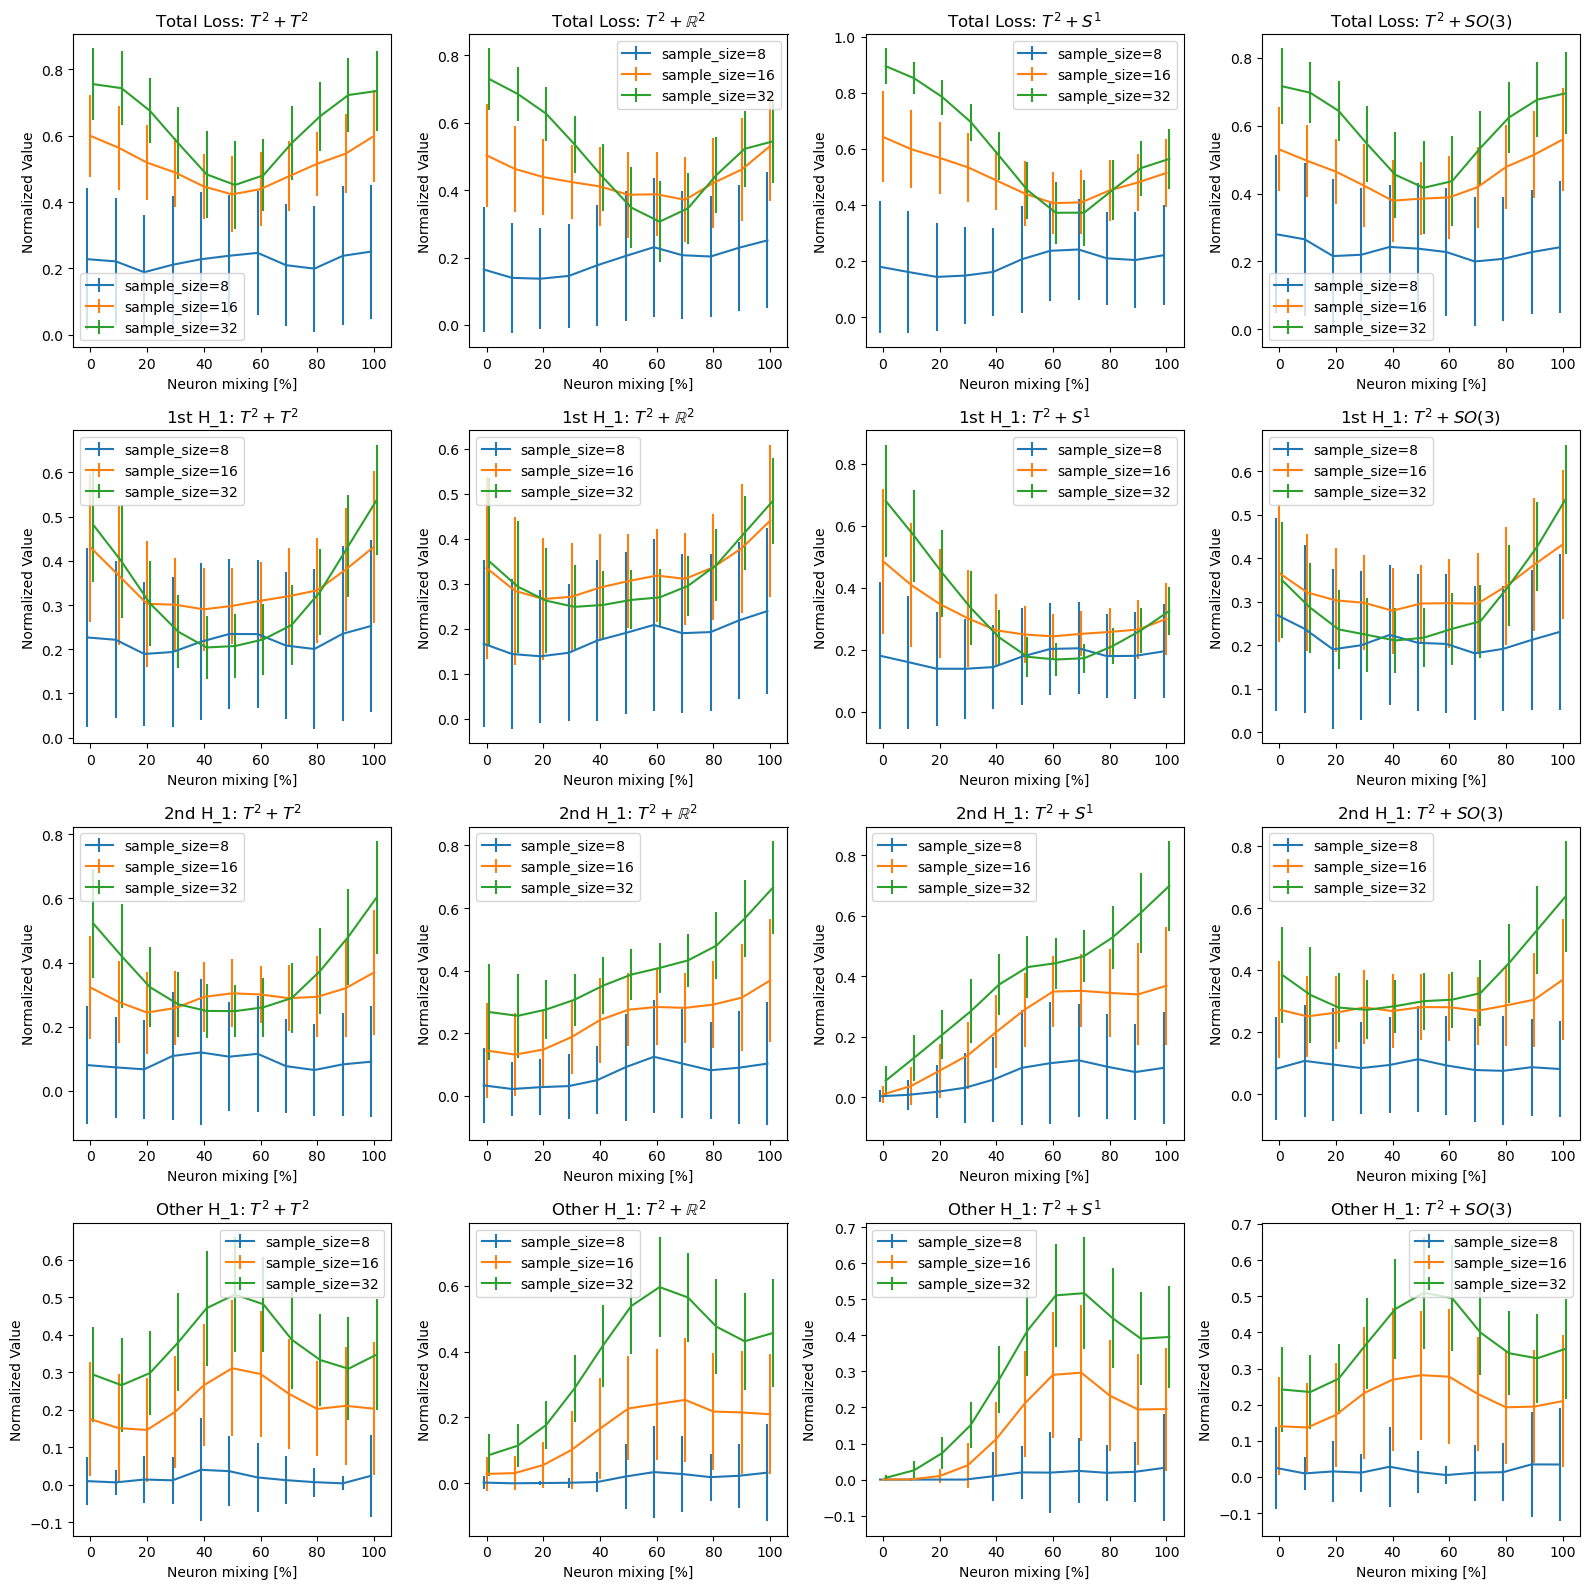

In [14]:
# Plot results
values = np.load('results/test_objective_function.npy')
labels = ["Total Loss: ", "1st H_1: ", "2nd H_1: ", "Other H_1: "]
plt.figure(figsize=(num_settings * 4, 4 * 4))

for j, l in enumerate(labels):
    for s in range(num_settings):
        plt.subplot(4, num_settings, s + 1 + j * num_settings)
        normed = values[s, ..., j].copy()
        normed -= np.min(normed, axis=(1, 2), keepdims=True)
        normed /= np.max(normed, axis=(1, 2), keepdims=True)

        for i, num_sample in enumerate(num_samples):
            plt.errorbar(num_mix + (i - 1) * 1, 
                         normed[i].mean(1), 
                         normed[i].std(1), 
                         label='sample_size=%s' % num_sample)
        plt.legend()
        plt.ylabel("Normalized Value")
        plt.xlabel("Neuron mixing [%]")
        plt.title(l + titles[s])
plt.tight_layout()
plt.show()

Each column in the plots above indicates one of the tested setting (i.e., combinations of neural ensembles from different manifolds). The x-axis in each plot indicates how many neurons came from the $T^2$ ensemble. Thus, high values on the right indicate a preference for selecting the $T^2$ ensemble, whereas high values on the left indicate a preference for selecting the other ensemble in each of the comparisons. Each row shows different measures of the persistence diagrams. The first row shows the proposed topological objective function (negative of the loss function defined in 2.2). The second (third) row gives the lifetime of the longest (second longest) $H_1$ in the persistence diagram. The fourth row gives the sum over all the other $H_1$ lifetimes. We can make a number of interesting observations based on these results:

For $T^2+T^2$ (first column), we can see that even with as little as $16$ temporal samples (i.e., columns of our data matrix) we see an increase in the topological objective function as we move from a perfectly mixed (mixing$=50\%$) to a perfectly separated (mixing$=100\%$) population of neurons. The second and third row indicate that the lifetimes of both top $H_1$ circles increases in this process. Interestingly, the fourth row shows that we first see a dip and then again a slight increase in the summer lifetimes over all other $H_1$ circles. This final sligh increase explains the levelling of in the total loss (first row). Moreover, as expected, this curve is symmetric in both directions since we have two symmetric toroidal ensembles. We will revisit the ensuing problem of <i>symmetry breaking</i> below.

For $T^2+\mathbb{R}^2$ (second column), we see also a little increase on the right hand side of the plot. However, we now also see an even higher increase on the left hand side. The second row indicates that is is partially driven by a spurious $H_1$ appearing in the $\mathbb{R}^2$ ensemble (but no second second $H_2$ as seen in the third row). Additionally, the last row shows now very clearly that we get a lot of $H_1$ circles in the data as we are moving towards the $T^2$ ensemble, which is expected since a torus is made up of these. However, we also note that in composition this results in a total loss (first row) which overall favours the $\mathbb{R}^2$ ensemble.

For $T^2+S^1$ (third column), the picture is rather similar to the one seen in $T^2+\mathbb{R}^2$. However, we now know that the top $H_1$ (second row) is significant reflecting a true feature of the $S^1$ ensemble; and the second longest $H_1$ (third row) is even more clearly absent. 

For $T^2+SO(3)$ (fourth column), we see almost a symmetric total loss function (first row). This results from a preference for the significant top two $H_1$ circles (second and third row) in $T^2$ which are counteracted by the larger total number of circles (fourth row) in $T^2$ (although we see also more circles in $SO(3)$ than, e.g., in $S^1$ or $\mathbb{R}^2$ – which is expected).

The obvious question that this raises is of course: <i>what use is a loss function that selects the wrong thing?</i> In practice, this is not a real issue since we only need to separate the two ensembles and then we are done. We could always compute their respective persistence diagrams again after this separation and simply pick the one with the toroidal signature. One might also wonder if we could set up our loss function differently, e.g., by also maximizing the lifetime of the top $H_2$ – but this increases the computation burden considerably. Another approach, looking at the third row of the plot where we see a positive incline to the right for all settings, would be to only maximize the lifetime of the second longest $H_1$. However, simulations have shown that, while this more often selects the correct toroidal ensemble, this takes much longer to optimize because, effectively, we are only computing gradients for a single simplical complex and thus much less of the data. Finally, dropping the term in the loss function that aims at minimizing the sum over all other (after the first top two) $H_1$ might also seem like a good idea since again we see an incline across the last row (which is subtracted in the total loss). Again, simulations have shown that this really slows down and also reduces the success of our optimization, possibly due to the convex combination of the original data that we are feeding into the persistence computation.

In any case, for the task that we set out, this is promising! As a next step we will now investigate whether we can use this to get useful gradients that will allow us to separate the different ensembles.

## 4.3. Introducing Teddy **🧸**

Topological Ensemble Detection with Differentiable Yoking (Teddy) is based on two critical components:

<ol>
  <li>Differentiable persistent homology.</li>
  <li>A continuous relaxation of discrete optimzation in an overparameterized model.</li>
</ol>

We use 1. [Brüel-Gabrielsson et al., 2020](https://arxiv.org/pdf/1905.12200.pdf)) to optimize a gradient directly for a combination of neurons that fits the expected signature of a toroidal ensemble. And we use 2. [Loog et al., 2020](https://www.pnas.org/content/pnas/117/20/10625.full.pdf) as a way to circumvent the discrete optimization of finding a subset of neurons, by searching instead for a convex combination of our neurons that maximizes the topological objective function. This, unnecessarily, increases the number of parameters in our model from $O(N)$ to $O(N^2)$, where $N$ is the number of neurons. However, early experiments showed that this was crucial for getting the optimization scheme to work. We leave further exploration of this phenomenon for future research.

In [15]:
# Parameters
signature = (1, 2)  # optimize the first {signature[1]} H_{signature[0]}
batch_size = 16
epochs = 500
max_steps = 100000  # maximum number of iterations
log_steps = 100
lr = 1e-2
num_worse = 50  # how many epochs loss may get worse before (early) stopping
stop_accuracy = 1.00  # train completely

We also set a more realistic recording time, since we take random samples from a larger pool with Teddy than what we used for persistent homology (PH) computation above. There, we took a shorter sample because it was sufficient to see the topological signature and faster to compute. A realistic full recording length will not be feasible for PH computation. Notably, this is not a crucial choice for our algorithm and we challenge the user to scale it back down to the same number of data points as used above.

In [16]:
# Set realistic recording length
num_data = 10000

<h4><center>Disclaimer: The next cell takes approx. 25min (on the machine used, see below) for 100 repetitions. If this exceeds the allowed computation time, simply adjust the number of repetitions. Alternatively, skip and load results from `results` folder.</center></h4>

Running Teddy on: T2+T2


  7%|▋         | 6700/100000 [01:42<23:48, 65.31it/s, loss_top=19.5, loss_rest=0.631, loss=-18.9, accuracy=1]        


Training finished: Stop (done) at iteration 6700


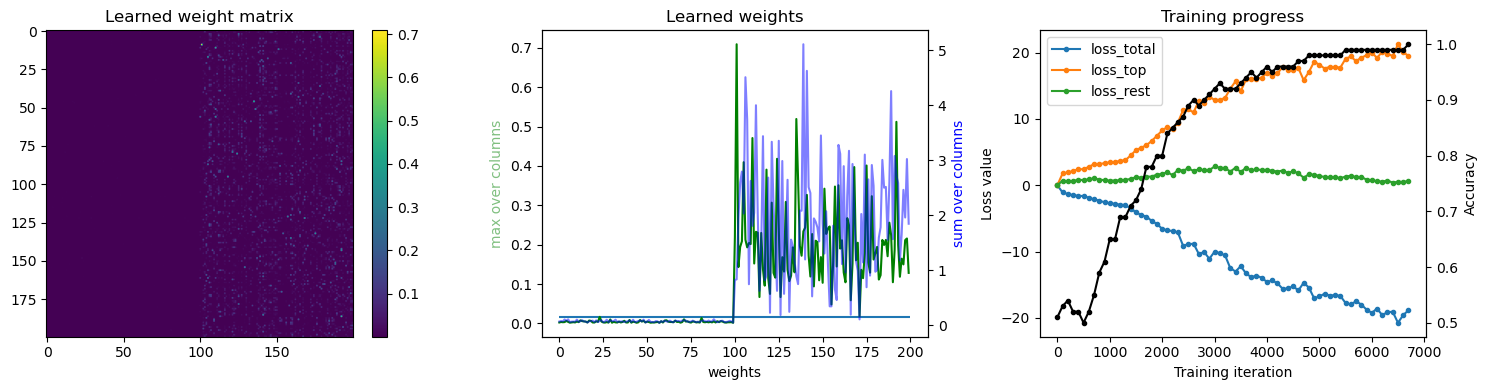



Running Teddy on: T2+R2


  8%|▊         | 8400/100000 [02:08<23:17, 65.54it/s, loss_top=26.7, loss_rest=3.29, loss=-23.4, accuracy=1]   


Training finished: Stop (done) at iteration 8400


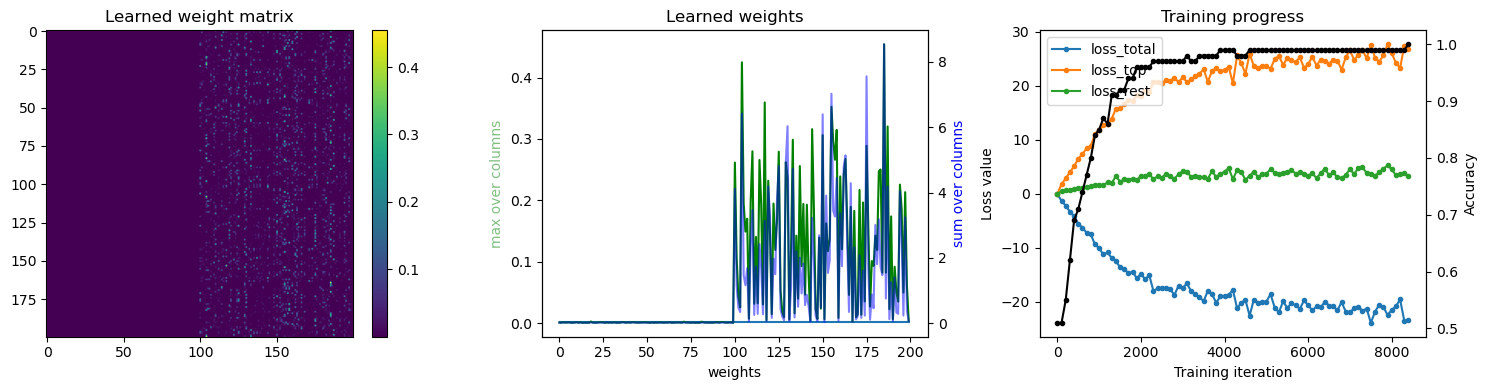



Running Teddy on: T2+S1


  2%|▏         | 2300/100000 [00:35<24:48, 65.65it/s, loss_top=27.7, loss_rest=0, loss=-27.7, accuracy=1]          


Training finished: Stop (done) at iteration 2300


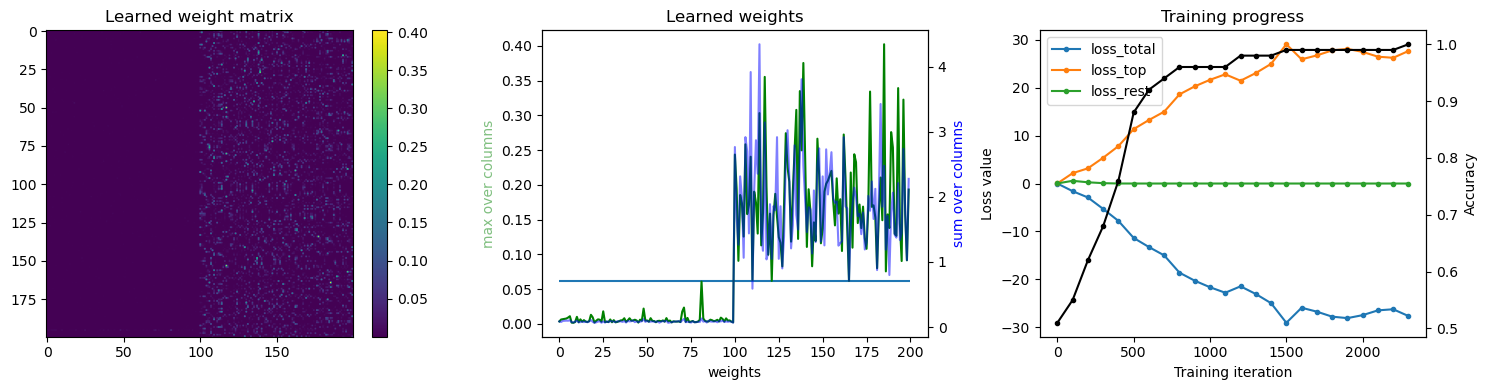



Running Teddy on: T2+SO3


 16%|█▋        | 16400/100000 [20:43<1:45:37, 13.19it/s, loss_top=23.1, loss_rest=5.84, loss=-17.2, accuracy=1]   


Training finished: Stop (done) at iteration 16400


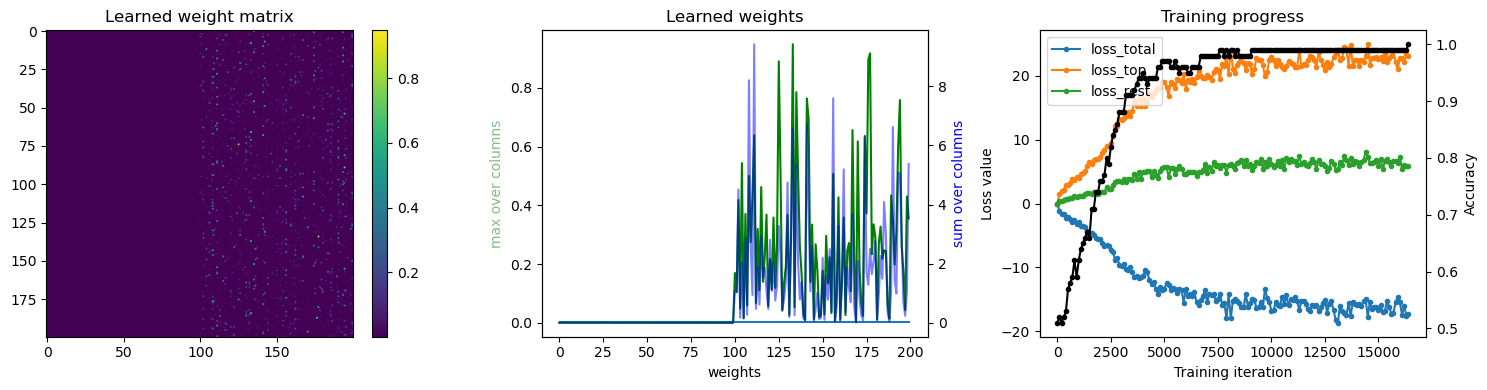



Cell execution took 25.26m


In [17]:
# Iterate once over all settings and plot results
t0 = time.time()
for setting in settings:
    print("Running Teddy on:", setting)
    mixed_responses = make_population(setting, manifolds, num_neurons, 
                                      num_data, sigmas, scales, global_seed)
    num_ensemble = mixed_responses.shape[0] // num_neurons
    labels = np.repeat(np.arange(num_ensemble), num_neurons)
    teddy = Teddy(mixed_responses, labels=labels, signature=signature,
                  batch_size=batch_size, max_steps=max_steps,
                  lr=lr, device=device, num_worse=num_worse,
                  stop_accuracy=stop_accuracy, log_steps=log_steps,
                  verbose=True, seed=global_seed + 820447,
                  save_file='results/single_run_setting=%s' % setting)
    teddy.train()
    print("\n")
print("Cell execution took %.2fm" % ((time.time() - t0) / 60))

<img src="https://previews.123rf.com/images/socris79/socris791709/socris79170900140/86815718-teddyb%C3%A4r-h%C3%A4lt-schokoladenkuchen-donut.jpg" alt="Drawing" style="width: 100px;"/>

<h4><center>Teddy found a torus.</center></h4>

We see that Teddy is able to separate the two ensembles in all settings. Moreover, we make the following observations:

<ul>
  <li>For $T^2 + T^2$, Teddy randomly (we check this below) selects one of the two tori. This requires <i>symmetry-breaking</i>, which we discuss below.</li>
  <li>For $T^2 + \mathbb{R}^2$, Teddy selects $\mathbb{R}^2$. We saw above that $\mathbb{R}^2$ does indeed lead to a higher value in the topological objective function due to a combination of a spurious top $H_1$ and more non-significant $H_1$ circles in $T^2$.</li>
  <li>For $T^2 + S^1$, Teddy selects $S^1$. Again, this is in line with our observations above where the top $H_1$ from $S^1$ clearly led to a higher value in the topological objective function (combined with fewer other $H_1$s).</li>
  <li>For $T^2 + SO(3)$, Teddy selects $SO(3)$. This is marginally surprising since we speculated above that both $T^2$ and $SO(3)$ present similar solution qualilties in terms of the topological objective function.</li>
</ul>

Below, we will investigate further how often Teddy prefers one solution over the other. To do this we will run each setting again over a number of random seeds for data generation and intialization. This also allows us to study the average performance of our method (independent of the random seed in the simulations above).

<h4><center>Disclaimer: The next cell takes approx. 159min (on the machine used, see below) for 20 repetitions. If this exceeds the allowed computation time, simply adjust the number of repetitions. Alternatively, skip and load results from `results` folder.</center></h4>

In [18]:
# Compute performance over multiple random seeds to compute average performance
t0 = time.time()
num_rep = 20  # number of repetitions
# to avoid long convergence times, we stop training when accuracy hits:
stop_accuracy = 0.9

# Let's try all settings
for setting in settings:
    for i in range(num_rep):
        print("Running Teddy on:", setting, "Run", i)
        mixed_responses = make_population(
            setting, manifolds, num_neurons, num_data,
            sigmas, scales, global_seed + 8398 * i
        )
        num_ensemble = mixed_responses.shape[0] // num_neurons
        labels = np.repeat(np.arange(num_ensemble), num_neurons)
        teddy = Teddy(mixed_responses, labels=labels, signature=signature,
                      batch_size=batch_size, max_steps=max_steps,
                      lr=lr, device=device, num_worse=num_worse,
                      stop_accuracy=stop_accuracy, log_steps=log_steps,
                      verbose=False, seed=global_seed + 2357 * i,
                      save_file='results/setting=%s_run=%s' % (setting, i))
        teddy.train()
        print("\n")
print("Cell execution took %.2fm" % ((time.time() - t0) / 60))

Running Teddy on: T2+T2 Run 0


  4%|▍         | 4400/100000 [01:06<24:11, 65.88it/s, loss_top=14.4, loss_rest=2.76, loss=-11.6, accuracy=0.9]  


Training finished: Stop (done) at iteration 4400


Running Teddy on: T2+T2 Run 1


 22%|██▏       | 21500/100000 [05:25<19:48, 66.06it/s, loss_top=19.4, loss_rest=3.31, loss=-16.1, accuracy=0.9]   


Training finished: Stop (done) at iteration 21500


Running Teddy on: T2+T2 Run 2


  3%|▎         | 3100/100000 [00:46<24:28, 65.98it/s, loss_top=10.7, loss_rest=1.36, loss=-9.36, accuracy=0.9]   


Training finished: Stop (done) at iteration 3100


Running Teddy on: T2+T2 Run 3


 10%|▉         | 9700/100000 [02:28<23:05, 65.19it/s, loss_top=18.2, loss_rest=2.02, loss=-16.2, accuracy=0.9]     


Training finished: Stop (done) at iteration 9700


Running Teddy on: T2+T2 Run 4


 23%|██▎       | 23200/100000 [05:54<19:34, 65.41it/s, loss_top=14.4, loss_rest=3.47, loss=-10.9, accuracy=0.63]  


Training finished: Early stopping at iteration 23200


Running Teddy on: T2+T2 Run 5


  5%|▌         | 5400/100000 [01:22<24:10, 65.20it/s, loss_top=13.8, loss_rest=1.94, loss=-11.9, accuracy=0.9]    


Training finished: Stop (done) at iteration 5400


Running Teddy on: T2+T2 Run 6


  4%|▍         | 4500/100000 [01:09<24:27, 65.06it/s, loss_top=13.5, loss_rest=0.803, loss=-12.7, accuracy=0.9]    


Training finished: Stop (done) at iteration 4500


Running Teddy on: T2+T2 Run 7


  3%|▎         | 3100/100000 [00:47<24:46, 65.18it/s, loss_top=11.1, loss_rest=2.87, loss=-8.28, accuracy=0.9]     


Training finished: Stop (done) at iteration 3100


Running Teddy on: T2+T2 Run 8


  9%|▉         | 9000/100000 [02:16<23:05, 65.70it/s, loss_top=20.7, loss_rest=4.17, loss=-16.6, accuracy=0.9]   


Training finished: Stop (done) at iteration 9000


Running Teddy on: T2+T2 Run 9


  4%|▎         | 3600/100000 [00:54<24:29, 65.58it/s, loss_top=10.2, loss_rest=1.57, loss=-8.68, accuracy=0.9]  


Training finished: Stop (done) at iteration 3600


Running Teddy on: T2+T2 Run 10


 19%|█▉        | 19200/100000 [04:55<20:41, 65.07it/s, loss_top=18.2, loss_rest=4.3, loss=-13.9, accuracy=0.86]      


Training finished: Early stopping at iteration 19200


Running Teddy on: T2+T2 Run 11


  3%|▎         | 2700/100000 [00:42<25:47, 62.87it/s, loss_top=10.3, loss_rest=1.03, loss=-9.27, accuracy=0.9]     


Training finished: Stop (done) at iteration 2700


Running Teddy on: T2+T2 Run 12


 26%|██▌       | 26100/100000 [23:26<1:06:23, 18.55it/s, loss_top=14.7, loss_rest=3.98, loss=-10.7, accuracy=0.65] 


Training finished: Early stopping at iteration 26100


Running Teddy on: T2+T2 Run 13


 38%|███▊      | 37700/100000 [09:29<15:41, 66.20it/s, loss_top=22.5, loss_rest=5.33, loss=-17.2, accuracy=0.9]    


Training finished: Stop (done) at iteration 37700


Running Teddy on: T2+T2 Run 14


  7%|▋         | 7300/100000 [01:50<23:20, 66.19it/s, loss_top=17.4, loss_rest=1.38, loss=-16, accuracy=0.9]    


Training finished: Stop (done) at iteration 7300


Running Teddy on: T2+T2 Run 15


  2%|▏         | 2200/100000 [00:33<24:46, 65.79it/s, loss_top=12, loss_rest=0.208, loss=-11.8, accuracy=0.91]    


Training finished: Stop (done) at iteration 2200


Running Teddy on: T2+T2 Run 16


 21%|██▏       | 21400/100000 [05:25<19:56, 65.69it/s, loss_top=15, loss_rest=4.37, loss=-10.7, accuracy=0.7]      


Training finished: Early stopping at iteration 21400


Running Teddy on: T2+T2 Run 17


  3%|▎         | 2800/100000 [00:42<24:40, 65.67it/s, loss_top=11.9, loss_rest=1.13, loss=-10.8, accuracy=0.9]     


Training finished: Stop (done) at iteration 2800


Running Teddy on: T2+T2 Run 18


  2%|▏         | 2100/100000 [00:32<24:53, 65.53it/s, loss_top=11.4, loss_rest=0.549, loss=-10.9, accuracy=0.9] 


Training finished: Stop (done) at iteration 2100


Running Teddy on: T2+T2 Run 19


 17%|█▋        | 17000/100000 [04:19<21:07, 65.46it/s, loss_top=21.5, loss_rest=4.24, loss=-17.3, accuracy=0.9]    


Training finished: Stop (done) at iteration 17000


Running Teddy on: T2+R2 Run 0


  2%|▏         | 1600/100000 [00:24<25:12, 65.04it/s, loss_top=14.1, loss_rest=2.09, loss=-12, accuracy=0.91]  


Training finished: Stop (done) at iteration 1600


Running Teddy on: T2+R2 Run 1


  3%|▎         | 2800/100000 [00:43<25:11, 64.29it/s, loss_top=18.8, loss_rest=2.76, loss=-16, accuracy=0.91]     


Training finished: Stop (done) at iteration 2800


Running Teddy on: T2+R2 Run 2


  2%|▏         | 1600/100000 [00:24<24:59, 65.63it/s, loss_top=15, loss_rest=2, loss=-13, accuracy=0.91]       


Training finished: Stop (done) at iteration 1600


Running Teddy on: T2+R2 Run 3


  2%|▏         | 1500/100000 [05:44<6:16:32,  4.36it/s, loss_top=12.9, loss_rest=1.68, loss=-11.2, accuracy=0.91]       


Training finished: Stop (done) at iteration 1500


Running Teddy on: T2+R2 Run 4


  1%|▏         | 1400/100000 [00:22<25:51, 63.57it/s, loss_top=14.4, loss_rest=2.01, loss=-12.3, accuracy=0.9]       


Training finished: Stop (done) at iteration 1400


Running Teddy on: T2+R2 Run 5


  2%|▏         | 1800/100000 [00:27<25:26, 64.35it/s, loss_top=14.7, loss_rest=1.88, loss=-12.8, accuracy=0.9]     


Training finished: Stop (done) at iteration 1800


Running Teddy on: T2+R2 Run 6


  1%|          | 1200/100000 [00:18<25:09, 65.46it/s, loss_top=13.8, loss_rest=2.26, loss=-11.6, accuracy=0.9]      


Training finished: Stop (done) at iteration 1200


Running Teddy on: T2+R2 Run 7


  2%|▏         | 1900/100000 [00:29<25:10, 64.96it/s, loss_top=16.1, loss_rest=2.67, loss=-13.4, accuracy=0.91]


Training finished: Stop (done) at iteration 1900


Running Teddy on: T2+R2 Run 8


  2%|▏         | 1600/100000 [00:24<25:00, 65.59it/s, loss_top=14.8, loss_rest=2.04, loss=-12.8, accuracy=0.9] 


Training finished: Stop (done) at iteration 1600


Running Teddy on: T2+R2 Run 9


  2%|▏         | 1700/100000 [00:25<24:56, 65.71it/s, loss_top=13.8, loss_rest=2.12, loss=-11.7, accuracy=0.9]     


Training finished: Stop (done) at iteration 1700


Running Teddy on: T2+R2 Run 10


  2%|▏         | 2100/100000 [00:32<25:01, 65.20it/s, loss_top=18.4, loss_rest=2.72, loss=-15.7, accuracy=0.9]     


Training finished: Stop (done) at iteration 2100


Running Teddy on: T2+R2 Run 11


  2%|▏         | 1500/100000 [00:22<25:02, 65.54it/s, loss_top=15.4, loss_rest=1.88, loss=-13.5, accuracy=0.92]      


Training finished: Stop (done) at iteration 1500


Running Teddy on: T2+R2 Run 12


  2%|▏         | 1500/100000 [00:22<25:06, 65.38it/s, loss_top=13, loss_rest=2, loss=-11, accuracy=0.91]             


Training finished: Stop (done) at iteration 1500


Running Teddy on: T2+R2 Run 13


  1%|▏         | 1400/100000 [00:21<25:00, 65.70it/s, loss_top=14.9, loss_rest=2.32, loss=-12.6, accuracy=0.9]     


Training finished: Stop (done) at iteration 1400


Running Teddy on: T2+R2 Run 14


  2%|▏         | 2300/100000 [00:34<24:45, 65.75it/s, loss_top=18.9, loss_rest=2.92, loss=-15.9, accuracy=0.9]      


Training finished: Stop (done) at iteration 2300


Running Teddy on: T2+R2 Run 15


  1%|▏         | 1400/100000 [00:21<25:04, 65.52it/s, loss_top=14, loss_rest=2, loss=-12, accuracy=0.9]             


Training finished: Stop (done) at iteration 1400


Running Teddy on: T2+R2 Run 16


  2%|▏         | 1500/100000 [00:22<25:00, 65.65it/s, loss_top=13.7, loss_rest=1.6, loss=-12.1, accuracy=0.9]  


Training finished: Stop (done) at iteration 1500


Running Teddy on: T2+R2 Run 17


  2%|▏         | 2100/100000 [00:31<24:48, 65.78it/s, loss_top=15, loss_rest=2.15, loss=-12.9, accuracy=0.9]   


Training finished: Stop (done) at iteration 2100


Running Teddy on: T2+R2 Run 18


  6%|▌         | 6000/100000 [01:31<23:47, 65.86it/s, loss_top=24.3, loss_rest=2.98, loss=-21.3, accuracy=0.9]  


Training finished: Stop (done) at iteration 6000


Running Teddy on: T2+R2 Run 19


  2%|▏         | 1500/100000 [00:22<25:03, 65.52it/s, loss_top=15.9, loss_rest=2.5, loss=-13.4, accuracy=0.9]  


Training finished: Stop (done) at iteration 1500


Running Teddy on: T2+S1 Run 0


  1%|          | 700/100000 [00:10<25:11, 65.72it/s, loss_top=15.1, loss_rest=0, loss=-15.1, accuracy=0.9]       


Training finished: Stop (done) at iteration 700


Running Teddy on: T2+S1 Run 1


  1%|          | 1100/100000 [00:16<25:01, 65.87it/s, loss_top=18.7, loss_rest=0, loss=-18.7, accuracy=0.9]       


Training finished: Stop (done) at iteration 1100


Running Teddy on: T2+S1 Run 2


  1%|          | 600/100000 [00:09<25:16, 65.54it/s, loss_top=15.2, loss_rest=0, loss=-15.2, accuracy=0.94]      


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 3


  1%|          | 600/100000 [00:09<25:11, 65.77it/s, loss_top=15.9, loss_rest=0, loss=-15.9, accuracy=0.93]        


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 4


  1%|          | 600/100000 [00:09<25:19, 65.43it/s, loss_top=16, loss_rest=0.00166, loss=-16, accuracy=0.93]      


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 5


  1%|          | 600/100000 [00:09<25:09, 65.85it/s, loss_top=13.5, loss_rest=0, loss=-13.5, accuracy=0.94]        


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 6


  0%|          | 500/100000 [00:07<25:17, 65.57it/s, loss_top=13, loss_rest=0, loss=-13, accuracy=0.92]         


Training finished: Stop (done) at iteration 500


Running Teddy on: T2+S1 Run 7


  1%|          | 700/100000 [00:10<25:09, 65.78it/s, loss_top=15.4, loss_rest=0, loss=-15.4, accuracy=0.92]      


Training finished: Stop (done) at iteration 700


Running Teddy on: T2+S1 Run 8


  1%|          | 600/100000 [00:09<25:09, 65.85it/s, loss_top=13.9, loss_rest=0, loss=-13.9, accuracy=0.91]        


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 9


  1%|          | 1200/100000 [00:18<24:58, 65.91it/s, loss_top=21, loss_rest=0, loss=-21, accuracy=0.9]           


Training finished: Stop (done) at iteration 1200


Running Teddy on: T2+S1 Run 10


  1%|          | 600/100000 [00:09<25:10, 65.81it/s, loss_top=15.7, loss_rest=0, loss=-15.7, accuracy=0.93]      


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 11


  1%|          | 600/100000 [00:09<25:13, 65.67it/s, loss_top=15.3, loss_rest=0, loss=-15.3, accuracy=0.92]      


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 12


  1%|          | 700/100000 [00:10<25:11, 65.68it/s, loss_top=16.4, loss_rest=0, loss=-16.4, accuracy=0.93]       


Training finished: Stop (done) at iteration 700


Running Teddy on: T2+S1 Run 13


  1%|          | 600/100000 [00:09<25:13, 65.67it/s, loss_top=13.5, loss_rest=0, loss=-13.5, accuracy=0.93]        


Training finished: Stop (done) at iteration 600


Running Teddy on: T2+S1 Run 14


  1%|          | 700/100000 [00:10<25:31, 64.84it/s, loss_top=13.5, loss_rest=0.00274, loss=-13.5, accuracy=0.9]  


Training finished: Stop (done) at iteration 700


Running Teddy on: T2+S1 Run 15


  0%|          | 500/100000 [00:07<25:18, 65.54it/s, loss_top=12.2, loss_rest=0, loss=-12.2, accuracy=0.9]        


Training finished: Stop (done) at iteration 500


Running Teddy on: T2+S1 Run 16


  0%|          | 500/100000 [00:07<25:47, 64.28it/s, loss_top=13.3, loss_rest=0, loss=-13.3, accuracy=0.94]         


Training finished: Stop (done) at iteration 500


Running Teddy on: T2+S1 Run 17


  1%|          | 700/100000 [00:11<26:27, 62.54it/s, loss_top=15.2, loss_rest=0.0042, loss=-15.2, accuracy=0.94]      


Training finished: Stop (done) at iteration 700


Running Teddy on: T2+S1 Run 18


  0%|          | 500/100000 [00:07<25:17, 65.56it/s, loss_top=12.3, loss_rest=0, loss=-12.3, accuracy=0.91]        


Training finished: Stop (done) at iteration 500


Running Teddy on: T2+S1 Run 19


  1%|          | 700/100000 [00:10<25:10, 65.74it/s, loss_top=14.2, loss_rest=0.0106, loss=-14.2, accuracy=0.92]


Training finished: Stop (done) at iteration 700


Running Teddy on: T2+SO3 Run 0


  3%|▎         | 2800/100000 [17:29<10:07:18,  2.67it/s, loss_top=10.5, loss_rest=2.57, loss=-7.95, accuracy=0.9]  


Training finished: Stop (done) at iteration 2800


Running Teddy on: T2+SO3 Run 1


 21%|██▏       | 21400/100000 [05:24<19:52, 65.94it/s, loss_top=19.4, loss_rest=5.09, loss=-14.3, accuracy=0.82]


Training finished: Early stopping at iteration 21400


Running Teddy on: T2+SO3 Run 2


  3%|▎         | 2600/100000 [00:39<24:36, 65.97it/s, loss_top=10.7, loss_rest=2.87, loss=-7.82, accuracy=0.91]


Training finished: Stop (done) at iteration 2600


Running Teddy on: T2+SO3 Run 3


  2%|▏         | 2400/100000 [00:36<24:44, 65.75it/s, loss_top=10.3, loss_rest=3.09, loss=-7.19, accuracy=0.91]     


Training finished: Stop (done) at iteration 2400


Running Teddy on: T2+SO3 Run 4


  2%|▎         | 2500/100000 [00:38<24:47, 65.56it/s, loss_top=11, loss_rest=2.66, loss=-8.39, accuracy=0.9]       


Training finished: Stop (done) at iteration 2500


Running Teddy on: T2+SO3 Run 5


 14%|█▍        | 14500/100000 [03:39<21:34, 66.05it/s, loss_top=20.5, loss_rest=4.37, loss=-16.1, accuracy=0.91]


Training finished: Stop (done) at iteration 14500


Running Teddy on: T2+SO3 Run 6


 28%|██▊       | 28100/100000 [07:14<18:32, 64.65it/s, loss_top=19.5, loss_rest=4.14, loss=-15.4, accuracy=0.81]   


Training finished: Early stopping at iteration 28100


Running Teddy on: T2+SO3 Run 7


  5%|▌         | 5000/100000 [01:18<24:53, 63.60it/s, loss_top=17.6, loss_rest=3.77, loss=-13.8, accuracy=0.9] 


Training finished: Stop (done) at iteration 5000


Running Teddy on: T2+SO3 Run 8


  7%|▋         | 6800/100000 [01:45<24:10, 64.25it/s, loss_top=18, loss_rest=5.46, loss=-12.5, accuracy=0.91]      


Training finished: Stop (done) at iteration 6800


Running Teddy on: T2+SO3 Run 9


 23%|██▎       | 23400/100000 [06:02<19:47, 64.49it/s, loss_top=18.5, loss_rest=4.93, loss=-13.6, accuracy=0.79] 


Training finished: Early stopping at iteration 23400


Running Teddy on: T2+SO3 Run 10


 13%|█▎        | 13100/100000 [03:23<22:28, 64.45it/s, loss_top=21.2, loss_rest=5.95, loss=-15.2, accuracy=0.9] 


Training finished: Stop (done) at iteration 13100


Running Teddy on: T2+SO3 Run 11


  3%|▎         | 3100/100000 [00:47<24:50, 65.03it/s, loss_top=12.3, loss_rest=3.45, loss=-8.89, accuracy=0.9]       


Training finished: Stop (done) at iteration 3100


Running Teddy on: T2+SO3 Run 12


  4%|▍         | 4200/100000 [01:04<24:39, 64.76it/s, loss_top=13.9, loss_rest=2.97, loss=-10.9, accuracy=0.91]    


Training finished: Stop (done) at iteration 4200


Running Teddy on: T2+SO3 Run 13


  2%|▏         | 2300/100000 [00:36<25:36, 63.57it/s, loss_top=11.1, loss_rest=3.48, loss=-7.65, accuracy=0.9]       


Training finished: Stop (done) at iteration 2300


Running Teddy on: T2+SO3 Run 14


  5%|▍         | 4700/100000 [01:12<24:30, 64.81it/s, loss_top=14.4, loss_rest=2.8, loss=-11.6, accuracy=0.9]      


Training finished: Stop (done) at iteration 4700


Running Teddy on: T2+SO3 Run 15


  2%|▏         | 2100/100000 [00:32<25:13, 64.68it/s, loss_top=10.9, loss_rest=3.07, loss=-7.87, accuracy=0.9]    


Training finished: Stop (done) at iteration 2100


Running Teddy on: T2+SO3 Run 16


 38%|███▊      | 38300/100000 [09:56<16:00, 64.24it/s, loss_top=17.1, loss_rest=3.92, loss=-13.2, accuracy=0.52]    


Training finished: Early stopping at iteration 38300


Running Teddy on: T2+SO3 Run 17


  3%|▎         | 2700/100000 [00:42<25:41, 63.13it/s, loss_top=11, loss_rest=3.33, loss=-7.62, accuracy=0.9]        


Training finished: Stop (done) at iteration 2700


Running Teddy on: T2+SO3 Run 18


  4%|▍         | 4400/100000 [01:08<24:46, 64.31it/s, loss_top=11.7, loss_rest=2.71, loss=-9, accuracy=0.9]    


Training finished: Stop (done) at iteration 4400


Running Teddy on: T2+SO3 Run 19


  4%|▍         | 4200/100000 [01:05<24:51, 64.24it/s, loss_top=14.7, loss_rest=4.64, loss=-10.1, accuracy=0.9] 

Training finished: Stop (done) at iteration 4200


Cell execution took 159.63m


# 4.4 Analysis of Results

INFO: Substituting symbol R from STIXGeneral


Setting: T2+T2, Success rate: 0.8, Solution bias: 0.7, Median steps: 6450.00
Setting: T2+R2, Success rate: 1.0, Solution bias: 1.0, Median steps: 1700.00
Setting: T2+S1, Success rate: 1.0, Solution bias: 1.0, Median steps: 700.00
Setting: T2+SO3, Success rate: 0.8, Solution bias: 1.0, Median steps: 4400.00


INFO: Substituting symbol R from STIXGeneral


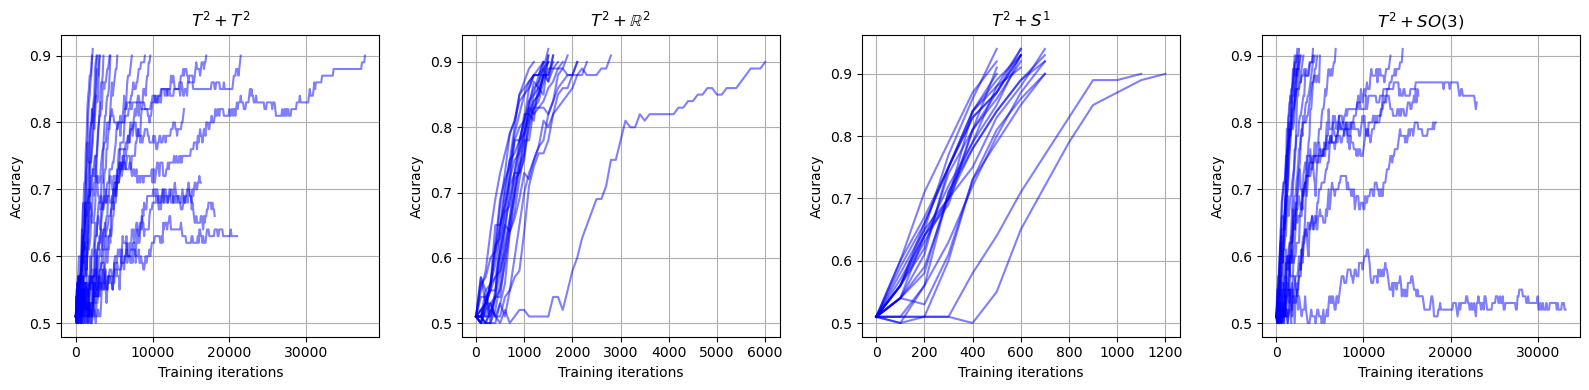

INFO: Substituting symbol R from STIXGeneral
INFO: Substituting symbol R from STIXGeneral


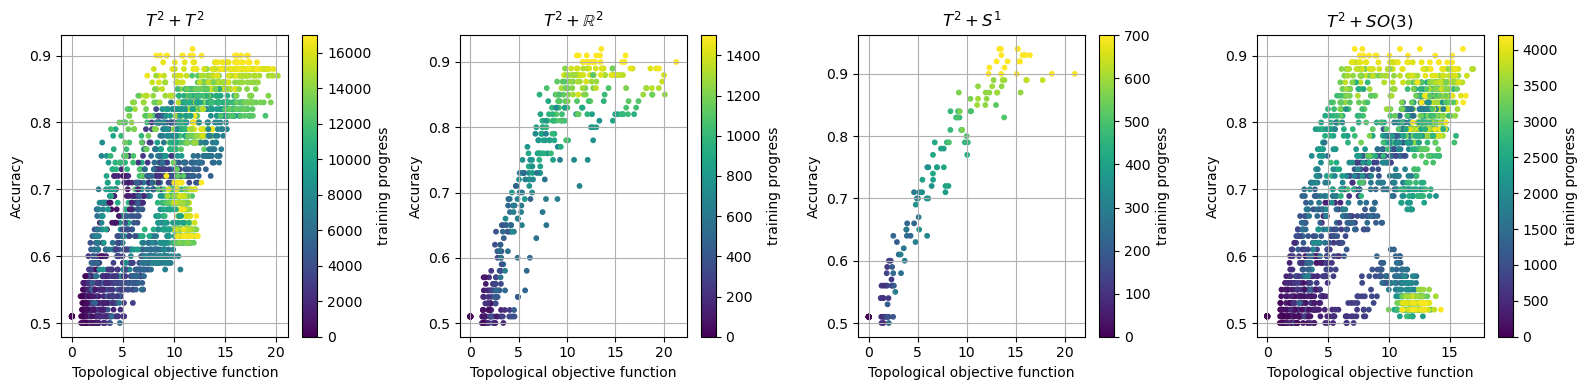

In [22]:
# Check to which solution the runs converged
labels = np.repeat(np.arange(2), num_neurons)
# Loading results
for setting in settings:
    solutions, success_rate, run_time = [], [], []
    for rep in range(num_rep):
        save_file = 'results/setting=%s_run=%s.pickle' % (setting, rep)
        with open(save_file, 'rb') as handle:
            out = pickle.load(handle)
        label = out['weights'].max(0)
        label = label > np.median(label)
        dominant_class = np.bincount(labels[label]).argmax()
        solutions.append(dominant_class)
        run_time.append(len(out['stats']['accuracy']) * log_steps)
        if out['stats']['accuracy'][-1] >= stop_accuracy:
            success_rate.append(1)
        else:
            success_rate.append(0)
            
    print("Setting: %s, Success rate: %s, Solution bias: %s, Median steps: %.2f" % (
        setting, gs.mean(success_rate), gs.mean(solutions), np.median(run_time)))
    
# Show runs
plt.figure(figsize=(16, 4))
for i, setting in enumerate(settings):
    plt.subplot(1, 4, i + 1)
    longest_run = 0
    for j in range(num_rep):
        save_file = 'results/setting=%s_run=%s.pickle' % (setting, j)
        with open(save_file, 'rb') as handle:
            out = pickle.load(handle)
        plt.plot(
            np.arange(len(out['stats']['accuracy'])) * log_steps,
            out['stats']['accuracy'], 
            color='blue', alpha=.5
        )
        if len(out['stats']['accuracy']) > longest_run:
            longest_run = len(out['stats']['accuracy'])
    plt.grid()
    plt.title(titles[i])
    plt.xlabel("Training iterations")
    plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# Check relation between accuracy and topological loss
plt.figure(figsize=(16, 4))
for i, setting in enumerate(settings):
    plt.subplot(1, 4, i + 1)
    for j in range(num_rep):
        save_file = 'results/setting=%s_run=%s.pickle' % (setting, j)
        with open(save_file, 'rb') as handle:
            out = pickle.load(handle)
        plt.scatter(
            - gs.array(out['stats']['loss']),
            out['stats']['accuracy'],
            c=np.arange(len(out['stats']['loss'])) * log_steps,
            s=10
        )
    plt.colorbar(label="training progress")
    plt.grid()
    plt.title(titles[i])
    plt.xlabel("Topological objective function")
    plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

We get perfect results for $T^2+\mathbb{R}^2$ and $T^2+S^1$ with a success rate of $1$. For the other two settings $T^2+T^2$ and $T^2+SO(3)$, we get a decent success rate of $0.8$. Looking at the individual runs (plots in top row), we see that most runs seem to be going in the right direction, but trigger the stopping criterion of our training. This could be fixed, but would increase the run time. Judging by the average number of steps, we have our settings in increasing order of difficulty as follows: $T^2+S^1$, $T^2+\mathbb{R}^2$, $T^2+SO(3)$ and $T^2+T^2$.

Next, we note that the setting $T^2+\mathbb{R}^2$ is likely unbiased (chance level being bias=$0.5$) as expected. However, in all other settings Teddy is clearly biased towards picking the alternative ensemble. While this solves the task we set out to do, it still provides food for thought and further study.

In the last row, we see that the value of the topological objective function is strongly related to the accuracy of our learning algorithm. That is, larger values in the objective are positively correlated with better task performance, which shows the consistency of our approach. This also suggests a simple remedy for the runs above that did not converge: run the algorithm over a few random seeds and pick the solution with the highest objective function value. Ideally, that should recover the right solution even if individual runs got stuck in local minima. A similar approach is the default setting for `sklearn`'s implementation of [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (see the `n_init` parameter there).

# 5. Conclusion

In this work we have provided a <i>proof-of-concept</i> for two data science challenges that we find exciting. Firstly, building an unsupervised clustering algorithm that can separate neural ensembles tuned to distinct latent variable manifolds, including $T^2, S^1, \mathbb{R}^2$ and $SO(3)$. Secondly, we proposed an overparameterized relaxation to a discrete optimization problem which we believe merrits more research in the future. Specifically, we would like to get a better understanding of the cosequences of computing a convex combination of the original data and its implications for the downstream computation of persistent homology.

We have repeatedly hinted at the problem of <i>symmetry-breaking</i> which comes up in the case of a mixed population where each ensemble comes from the same type of latent manifold ($T^2+T^2$ in our simulations). We note (results now shown) that changing the mean firing rate and, therefore, the signal to noise ratio (SNR) in one of the two ensembles immediately achieved this goal. Thus, this problem may be less of a nuisance in realistic settings where it is unlikely that we will ever record from two neural populations with identical SNR.

Moreover, we have seen that our algorithm tends to separate ensembles, however, preferring the non-intended solutions. Practically, we noted that this is not a concern since we just need to separate the two ensembles (or more, provided repeated application of Teddy). We can then post-hoc always compute the full persistence and choose the ensemble that we care about. Nevertheless, we believe that further theoretical investigation (and tinkering) will likely provide a more selective objective function that still results in a fast and robust optimization.

A limitation of our approach is that computing persistent homology is computationally burdening and also prone to noise. Further research is needed to investigate how both shortcoming might be improved (see Methods in [Gardner et al., 2022](https://www.nature.com/articles/s41586-021-04268-7)).

In [20]:
print("Complete notebook took %.2fh to execute (on a 8 CPU core M1 chip 2020 MacBook Pro machine)." % (
    (time.time() - global_t0) / 3600))

Complete notebook took 3.20h to execute (on a 8 CPU core M1 chip 2020 MacBook Pro machine).


<center><h1>🧸</h1></center>